In [140]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.decomposition import PCA
import json 



### Mixture Models
references: https://www.cs.toronto.edu/~rgrosse/csc321/mixture_models.pdf 

https://www.kaggle.com/code/minc33/visualizing-high-dimensional-clusters

In [141]:


df = pd.read_csv('data/data_merged_encoded.csv')

# Select numeric columns for the mixture model
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
X = df[numeric_columns].dropna()  # Drop rows with missing values
# print(X.columns)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Text(0, 0.5, 'BIC Score')

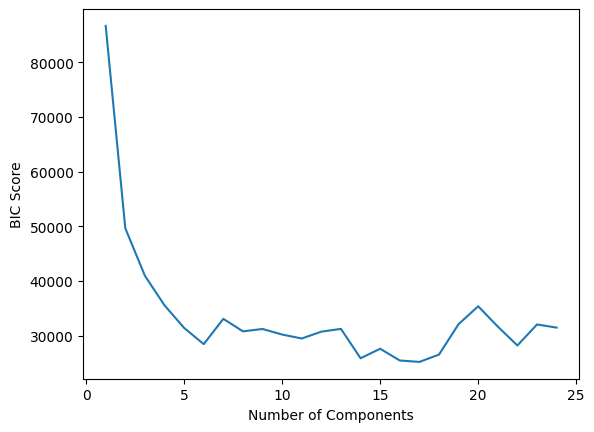

In [126]:
n_components_range = range(1, 25)
bics = []
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))

plt.plot(n_components_range, bics)
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')


In [127]:
print(min(bics), bics.index(min(bics)))

25209.96815787738 16


In [128]:
best_n_components = 16  # Example from BIC analysis
gmm = GaussianMixture(n_components=best_n_components, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
cluster_labels = gmm.predict(X_scaled)

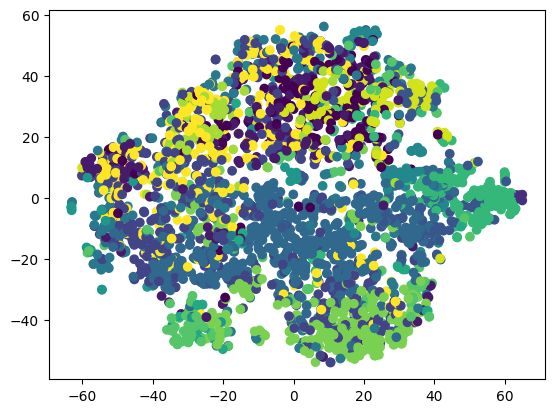

In [129]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis')

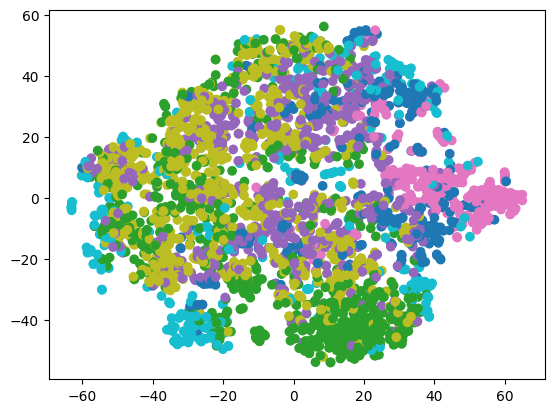

In [130]:
best_n_components = 6
gmm = GaussianMixture(n_components=best_n_components, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
cluster_labels = gmm.predict(X_scaled)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab10')

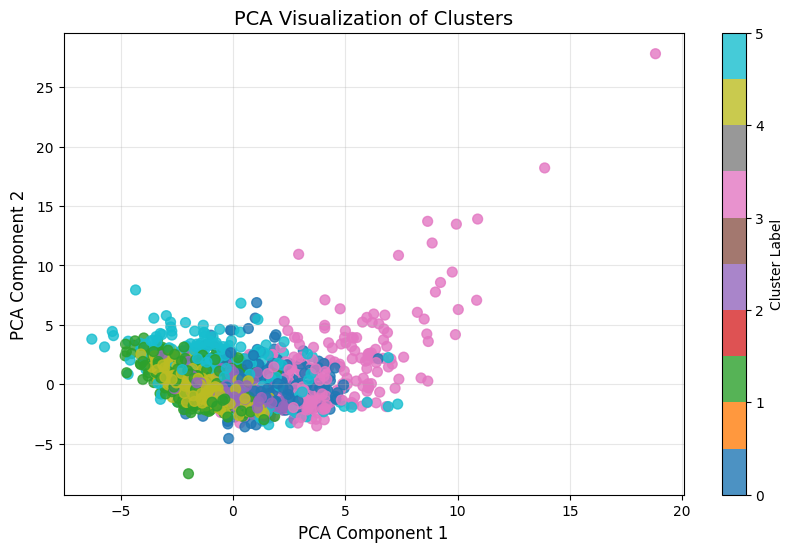

In [131]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Scatter plot with PCA components
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', s=50, alpha=0.8)
plt.colorbar(scatter, label='Cluster Label')
plt.title('PCA Visualization of Clusters', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [142]:
fips_mapping = pd.read_csv('data/FipsCountyCodes.csv')
df = df.merge(fips_mapping[['FIPS', 'Name']], left_on='FIPS', right_on='FIPS', how='left')


In [143]:
df['cluster'] = cluster_labels
df.head()

,FIPS,2024 Urban Influence Code,"Percent of adults who are not high school graduates, 2019-23","Percent of adults who are high school graduates (or equivalent), 2019-23","Percent of adults completing some college or associate degree, 2019-23","Percent of adults with a bachelor's degree or higher, 2019-23",Economic_typology_2015,NATURAL_CHG_2023,DOMESTIC_MIG_2023,R_BIRTH_2023,...,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Name,cluster
0,1001,-0.426905,-0.278537,-0.151198,-0.297658,0.418089,-0.995489,-0.051421,0.125382,0.480823,...,False,False,False,False,False,False,False,False,"AL, Autauga",2
1,1003,-0.426905,-0.543725,-0.822225,0.096189,0.862459,1.754927,-0.205564,1.747120,-0.246254,...,False,False,False,False,False,False,False,False,"AL, Baldwin",0
2,1005,-0.037317,1.997280,0.493048,-0.407219,-1.237164,0.654761,-0.185724,-0.012310,0.036498,...,False,False,False,False,False,False,False,False,"AL, Barbour",4
3,1007,-1.595670,1.536006,0.953446,-0.597235,-1.236820,-0.995489,-0.160542,-0.018475,0.076891,...,False,False,False,False,False,False,False,False,"AL, Bibb",4
4,1009,-1.595670,1.105865,0.233289,0.116699,-0.832226,-0.995489,-0.181909,0.091216,0.400036,...,False,False,False,False,False,False,False,False,"AL, Blount",2


In [56]:
# explained variance ratios 
components = pd.DataFrame(pca.components_, columns=df.columns, index=[f'PC{i+1}' for i in range(pca.n_components)])

explained_variance = pca.explained_variance_ratio_

# Find the most important features for each principal component
most_important_features = {}
for i in range(pca.n_components):
    pc = components.iloc[i]
    top_features = pc.abs().nlargest(5).index  # Get top 5 features by absolute value
    most_important_features[f'PC{i+1}'] = top_features.tolist()

# Display the results
print("Explained Variance Ratios:", explained_variance)
print("\nMost Important Features for Each Principal Component:")
for pc, features in most_important_features.items():
    print(f"{pc}: {features}")

ValueError: Shape of passed values is (3, 17), indices imply (3, 69)

###

### other viz 

In [72]:
#pca works better? 
pca = PCA(n_components=3, random_state=42)
X_pca_3d = pca.fit_transform(X_scaled)

fig = px.scatter_3d(
    x=X_pca_3d[:, 0], 
    y=X_pca_3d[:, 1], 
    z=X_pca_3d[:, 2],
    color=df['cluster'].astype(str),  
    hover_data={'County': df['Name']},  
    title='3D PCA Clustering'
)

fig.update_traces(marker_size=5)
fig.show()

In [86]:
import json
from urllib.request import urlopen

# Load the GeoJSON file
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

# Count the total number of FIPS codes
total_fips = len(counties['features'])

print(f"Total FIPS codes in the GeoJSON file: {total_fips}")

Total FIPS codes in the GeoJSON file: 3221


In [147]:
df["FIPS"] = df["FIPS"].astype(str).str.zfill(5) # https://github.com/plotly/datasets/issues/29

df['cluster'] = df['cluster'].astype(str)
df = df.sort_values(by='cluster')


fig = px.choropleth(
    df,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations='FIPS',  
    color='cluster',     
    color_discrete_sequence=px.colors.qualitative.Plotly,  
    scope="usa",
    hover_name='Name',  
    title='US County Clusters'
)

fig.update_geos(
    visible=False,
    bgcolor='rgba(0,0,0,0)'
)

fig.update_traces(
    marker_line_width=0.1,
    marker_opacity=0.8,
    hovertemplate="<b>%{customdata[0]}</b><br>" +  # Display the county name
                  "FIPS: %{location}<br>" +
                  "Cluster: %{color}<extra></extra>",
    customdata=df[['Name']].values  # Pass the 'Name' column as custom data
)


# Make layout adjustments
fig.update_layout(
    height=600,
    width=1000,
    margin={"r":0,"t":40,"l":0,"b":0},
    legend_title_text='Cluster'
)

fig.show()

### addressing wrong fips -> county mapping ?


In [ ]:
# csv from https://erddap.emodnet.eu/erddap/convert/fipscounty.html
# https://github.com/plotly/datasets/blob/master/geojson-counties-fips.json out of date 

In [139]:
df[df['FIPS']=="56013"]

,FIPS,2024 Urban Influence Code,"Percent of adults who are not high school graduates, 2019-23","Percent of adults who are high school graduates (or equivalent), 2019-23","Percent of adults completing some college or associate degree, 2019-23","Percent of adults with a bachelor's degree or higher, 2019-23",Economic_typology_2015,NATURAL_CHG_2023,DOMESTIC_MIG_2023,R_BIRTH_2023,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
3115,56013,0.74186,-0.872084,-0.342565,1.174585,0.120051,-0.995489,-0.17733,0.081197,0.157678,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
import geopandas as gpd
import pandas as pd
import plotly.express as px

# Load and prepare data
geo_gdf = gpd.read_file('data/counties_2018_500k.geojson')

# Standardize FIPS codes
geo_gdf['FIPS'] = geo_gdf['GEOID'].astype(str).str.zfill(5)
df['FIPS'] = df['FIPS'].astype(str).str.zfill(5)

merged_gdf = geo_gdf.merge(df, on='FIPS', how='left')
merged_gdf.to_file("data/merged_data.geojson", driver='GeoJSON') 
merged_gdf

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Name,cluster
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.0463, -89.17938 37.0530...",...,False,False,False,False,False,False,False,False,"KY, Ballard",1.0
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283...",...,False,False,False,False,False,False,False,False,"KY, Bourbon",4.0
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074...",...,False,False,False,False,False,False,False,False,"KY, Butler",1.0
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.6454, -84.12483 37.6461...",...,False,False,False,False,False,False,False,False,"KY, Estill",4.0
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450...",...,False,False,False,False,False,False,False,False,"KY, Fleming",4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,31,073,00835858,0500000US31073,31073,Gosper,06,1186616237,11831826,"POLYGON ((-100.0951 40.43866, -100.08937 40.43...",...,False,False,False,False,False,False,False,False,"NE, Gosper",1.0
3229,39,075,01074050,0500000US39075,39075,Holmes,06,1094405866,3695230,"POLYGON ((-82.22066 40.66758, -82.19327 40.667...",...,False,False,False,False,False,False,False,False,"OH, Holmes",5.0
3230,48,171,01383871,0500000US48171,48171,Gillespie,06,2740719114,9012764,"POLYGON ((-99.304 30.49983, -99.28234 30.49967...",...,True,False,False,False,False,False,False,False,"TX, Gillespie",5.0
3231,55,079,01581100,0500000US55079,55079,Milwaukee,06,625440563,2455383635,"POLYGON ((-88.06959 42.86726, -88.06959 42.872...",...,False,False,False,False,False,True,False,False,"WI, Milwaukee",3.0


In [ ]:
import json
import plotly.express as px

# 1. Convert GeoDataFrame to correct GeoJSON format
geojson_str = json.loads(merged_gdf.set_index('FIPS').to_json())  # Set FIPS as index

# 2. Ensure cluster is treated as categorical
merged_gdf['cluster'] = merged_gdf['cluster'].astype(str)  # Force discrete treatment

# 3. Create the choropleth with corrected parameters
fig = px.choropleth(
    merged_gdf,
    geojson=geojson_str,
    locations='FIPS',
    featureidkey="properties.FIPS",  # Critical: matches GeoJSON property
    color='cluster',
    hover_name='Name',
    hover_data={'FIPS': True, 'cluster': True, 'Name': False},  # Cleaner hover
    scope="usa",
    color_discrete_sequence=px.colors.qualitative.Plotly,
    category_orders={"cluster": sorted(merged_gdf['cluster'].unique())}  # Explicit ordering
)

# 4. Adjust map settings
fig.update_geos(
    fitbounds="locations",
    visible=False,
    subunitcolor='grey',  # Add state borders
    subunitwidth=0.5
)

# 5. Final layout tweaks
fig.update_layout(
    height=700,
    margin={"r":0,"t":0,"l":0,"b":0},
    legend_title_text='Cluster'
)

fig.show()